# San Francisco Crime Classification

In [147]:
import warnings
warnings.filterwarnings('ignore')

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import time

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

## Import Data
Import data and check the shape of train and test set.
We want to determine how to split out the train set into train and dev.

In [2]:
import csv
from datetime import datetime
from time import time
ff = "./Data/train.csv" # you will need to edit this directory
with open(ff, 'rt') as f:
    reader = csv.reader(f)
    train_data = list(reader)
ff = "./Data/test.csv" # you will need to edit this directory
with open(ff, 'rt') as f:
    reader = csv.reader(f)
    test_data = list(reader)
    
#Convert to pandas data frame for better analysis
train_data_full = pd.DataFrame(train_data[1:], columns = train_data[0])
test_data = pd.DataFrame(test_data[1:], columns = test_data[0])
print ("Shape of train data", train_data_full.shape)
print ("Shape of test data", test_data.shape)

('Shape of train data', (878049, 9))
('Shape of test data', (884262, 7))


Run basic totals

In [3]:
category_count = train_data_full.groupby(['Category'])['Dates'].count()

print ("Training Data: Top 5 crimes")
print (category_count.sort_values(ascending=False)[:5])
print ("")

print ("Training Data: Lowest 5 crimes")
print (category_count.sort_values(ascending=True)[:5])
print ("")

print ("Training Data: All Category Counts")
print (category_count.sort_values(ascending=False))
print ("")

print ("Training Data: Cumulative Sum of Counts for Top 5 Crimes")
print (category_count.sort_values(ascending=False)[:5].cumsum())

#Top 5 crimes make up over 50% of the training data set.
#Focusing on prediciting these as accurately as possible may give us a better accuracy score overall 

Training Data: Top 5 crimes
Category
LARCENY/THEFT     174900
OTHER OFFENSES    126182
NON-CRIMINAL       92304
ASSAULT            76876
DRUG/NARCOTIC      53971
Name: Dates, dtype: int64

Training Data: Lowest 5 crimes
Category
TREA                           6
PORNOGRAPHY/OBSCENE MAT       22
GAMBLING                     146
SEX OFFENSES NON FORCIBLE    148
EXTORTION                    256
Name: Dates, dtype: int64

Training Data: All Category Counts
Category
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SEC

Converting X and Y coordinates into San Francisco neighborhoods using Zillows database via shapefiles

Shapefiles can be read via the pyshp package (https://pypi.python.org/pypi/pyshp)

https://www.zillow.com/howto/api/neighborhood-boundaries.htm

In [4]:
#read in the shapefile provided by zillow for california
sf = shapefile.Reader("./Data/ZillowNeighborhoods-CA.shp")
fields = sf.fields[1:] 
field_names = [field[0] for field in fields] 
nhood_list = []

#iterate through the shapefile records and retrieve the properties of each shapefile record 
#as well as its bbox coordinates 
#bbox: If the shape type contains multiple points this tuple describes the lower left (x,y) 
#coordinate and upper right corner coordinate creating a complete box around the points. 
#If the shapeType is a Null (shapeType == 0) then an AttributeError is raised.

#we will use the bbox to determine if our X and Y coordinates from the training data
#fall within the bbox of each neighborhood and then assign that neighborhood to the training data
for r in sf.shapeRecords():  
    atr = dict(zip(field_names, r.record))
    bbox = r.shape.bbox
    if atr['City'] == 'San Francisco':
        #print (dict(properties=atr,bbox=bbox))
        new_dict=dict(properties=atr,bbox=bbox)
        nhood_list.append(new_dict)
        
def coord_in_bbox(bbox, X, Y):
    if X>=bbox[0] and X<=bbox[2] and Y>=bbox[1] and Y<=bbox[3]:
        return True
    else:
        return False

def neighborhood(nhood_list, X, Y):
    for n in nhood_list:
        bbox = n['bbox']
        X = float(X)
        Y = float(Y)
        if coord_in_bbox(bbox, X, Y):
            return n['properties']['Name']

#Add neighborhood to train data
train_data_full['Neighborhood'] = train_data_full.apply(lambda x: neighborhood(nhood_list,x['X'],x['Y']),axis=1)
        



Neighborhood Counts

In [5]:
neighborhood_count = train_data_full.groupby(['Neighborhood'])['Dates'].count()

print ("Training Data: Top 5 Criminal Neighborhoods")
print (neighborhood_count.sort_values(ascending=False)[:5])
print ("")

print ("Training Data: Lowest 5 Criminal Neighborhoods")
print (neighborhood_count.sort_values(ascending=True)[:5])
print ("")

print ("Training Data: All Neighborhood Counts")
print (neighborhood_count.sort_values(ascending=False))
print ("")

print ("Training Data: Cumulative Sum of Counts for Top 5 Neighborhoods")
print (neighborhood_count.sort_values(ascending=False)[:5].cumsum())

#Top 5 neighborhoods make up almost 50% of the training data set.
#Also next steps is to bring in the category counts by neighborhood to see how these relate as well.

Training Data: Top 5 Criminal Neighborhoods
Neighborhood
South of Market    174414
Downtown            90894
Mission             83617
South Beach         36298
Bayview             32651
Name: Dates, dtype: int64

Training Data: Lowest 5 Criminal Neighborhoods
Neighborhood
Monterey Heights     14
Clarendon Heights    15
Buena Vista Park     72
Balboa Terrace       78
Treasure Island      93
Name: Dates, dtype: int64

Training Data: All Neighborhood Counts
Neighborhood
South of Market                             174414
Downtown                                     90894
Mission                                      83617
South Beach                                  36298
Bayview                                      32651
Bernal Heights                               28829
Hunters Point                                22562
Hayes Valley                                 22519
Western Addition                             21963
Excelsior                                    21074
Haight-Ashbury   

## Generate Date and Time Features
Season  
Month  
Week  
Day / Day of Week  
Hour

In [6]:
#convert Dates to datetime
train_data_full['FinalDate'] = pd.to_datetime(train_data_full['Dates'], format='%Y-%m-%d %H:%M:%S')

In [7]:
#create functions to extract the needed datetime features
def season(date):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if date.timetuple().tm_yday in spring:
        return 2 #Spring
    elif date.timetuple().tm_yday in summer:
        return 3 #Summer
    elif date.timetuple().tm_yday in fall:
        return 4 #Fall
    else:
        return 1 #Winter
    
def getTimeCat(date):
    # extract time categories
    timecat = 4
    ts =  datetime.strptime(str(date),  '%Y-%m-%d %H:%M:%S').time()

    # --> Morning = 0400-1000
    mornStart = datetime.strptime('2016-12-31 04:01',  '%Y-%m-%d %H:%M').time()
    mornEnd = datetime.strptime('2016-12-31 10:00',  '%Y-%m-%d %H:%M').time()
    
    # --> Midday = 1000-1600
    midStart = datetime.strptime('2016-12-31 10:01',  '%Y-%m-%d %H:%M').time()
    midEnd = datetime.strptime('2016-12-31 16:00',  '%Y-%m-%d %H:%M').time()

    # --> Evening = 1600-2300
    eveStart = datetime.strptime('2016-12-31 16:01',  '%Y-%m-%d %H:%M').time()
    eveEnd = datetime.strptime('2016-12-31 23:00',  '%Y-%m-%d %H:%M').time()

    # --> Late Night = 2300-0400
    lateStart1 = datetime.strptime('2016-12-31 23:01',  '%Y-%m-%d %H:%M').time()
    lateEnd1 = datetime.strptime('2016-12-31 23:59',  '%Y-%m-%d %H:%M').time()
    lateStart2 = datetime.strptime('2016-12-31 00:01',  '%Y-%m-%d %H:%M').time()
    lateEnd2 = datetime.strptime('2016-12-31 04:01',  '%Y-%m-%d %H:%M').time()

    
    if ts >= mornStart and ts <= mornEnd:
      timecat = 0 #morning
    elif ts >= midStart and ts <= midEnd:
      timecat = 1 #midday
    elif ts >= eveStart and ts <= eveEnd:
      timecat = 2 #evening
    elif ts >= lateStart1 and ts <= lateEnd1:
      timecat = 3 #late night
    elif ts >= lateStart2 and ts <= lateEnd2:
      timecat = 3 #late night

    return timecat



(877982, 11)


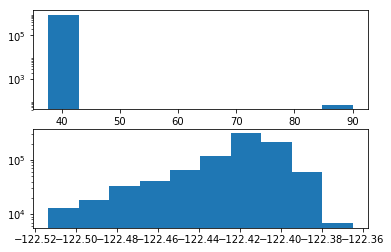

In [8]:
#Clean DF of Lat/Long Outliers
train_data_full["Y"] = train_data_full["Y"].astype(float)
train_data_full["X"] = train_data_full["X"].astype(float)

plt.subplot(211)
plt.hist(train_data_full["Y"])
plt.yscale('log', nonposy='clip')

train_data_full = train_data_full[train_data_full["Y"]<90]
print train_data_full.shape

plt.subplot(212)
plt.hist(train_data_full["X"])
plt.yscale('log', nonposy='clip')

In [9]:
#apply the functions
train_data_full['Season'] = train_data_full['FinalDate'].apply(lambda x: season(x))
train_data_full['Month'] = train_data_full['FinalDate'].apply(lambda x: x.month)
train_data_full['DayOfMonth'] = train_data_full['FinalDate'].apply(lambda x: x.day)
train_data_full['Week'] = train_data_full['FinalDate'].apply(lambda x: x.week)
train_data_full['TimeCat'] = train_data_full['FinalDate'].apply(lambda x: getTimeCat(x))
train_data_full['Hour'] = train_data_full['FinalDate'].apply(lambda x: x.hour)

Normalize and Standardize Date and X,Y

In [17]:
def normalize(series_field, df, new_field_name):
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    series_field = series_field.reshape((len(series_field), 1))
    scaler = scaler.fit(series_field)
    normalized = scaler.transform(series_field)
    df[new_field_name] = normalized
    return df

def standardize(series_field, df, new_field_name):
    scaler = preprocessing.StandardScaler()
    series_field = series_field.reshape((len(series_field), 1))
    scaler = scaler.fit(series_field)
    standardized = scaler.transform(series_field)
    df[new_field_name] = standardized
    return df

train_data_full = normalize(train_data_full['FinalDate'], train_data_full, 'DateNorm')
train_data_full = standardize(train_data_full['FinalDate'], train_data_full, 'DateStand')
train_data_full = normalize(train_data_full['X'], train_data_full, 'XNorm')
train_data_full = standardize(train_data_full['X'], train_data_full, 'XStand')
train_data_full = normalize(train_data_full['Y'], train_data_full, 'YNorm')
train_data_full = standardize(train_data_full['Y'], train_data_full, 'YStand')
train_data_full = standardize(train_data_full['DateNorm'], train_data_full, 'DateNS')
train_data_full = standardize(train_data_full['XNorm'], train_data_full, 'XNS')
train_data_full = standardize(train_data_full['YNorm'], train_data_full, 'YNS')

In [18]:
#get a list of features and their data types
train_data_full.dtypes

Dates                   object
Category                object
Descript                object
DayOfWeek               object
PdDistrict              object
Resolution              object
Address                 object
X                      float64
Y                      float64
Neighborhood            object
FinalDate       datetime64[ns]
Season                   int64
Month                    int64
DayOfMonth               int64
Week                     int64
TimeCat                  int64
Hour                     int64
DateNorm               float64
DateStand              float64
XNorm                  float64
XStand                 float64
YNorm                  float64
YStand                 float64
DateNS                 float64
XNS                    float64
YNS                    float64
dtype: object

In [19]:
#convert to matrix for model processing
#Create sets of data where time and coords are standardized, scaled from [0,1], both
X_full = train_data_full.as_matrix()
Y = train_data_full["Category"].as_matrix()
X = train_data_full[["Dates","X","Y"]].as_matrix()
X_Norm = train_data_full[["DateNorm","XNorm","YNorm"]].as_matrix()
X_Std = train_data_full[["DateStand","XStand","YStand"]].as_matrix()
X_NS = train_data_full[["DateNS","XNS","YNS"]].as_matrix()
#Data set to investigate importance of time dimension
X_2d = train_data_full[["XStand","YStand"]].as_matrix()

In [20]:
X_cat = train_data_full[["Hour","TimeCat","DayOfMonth", "Week","Month","Season","X","Y"]].as_matrix()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


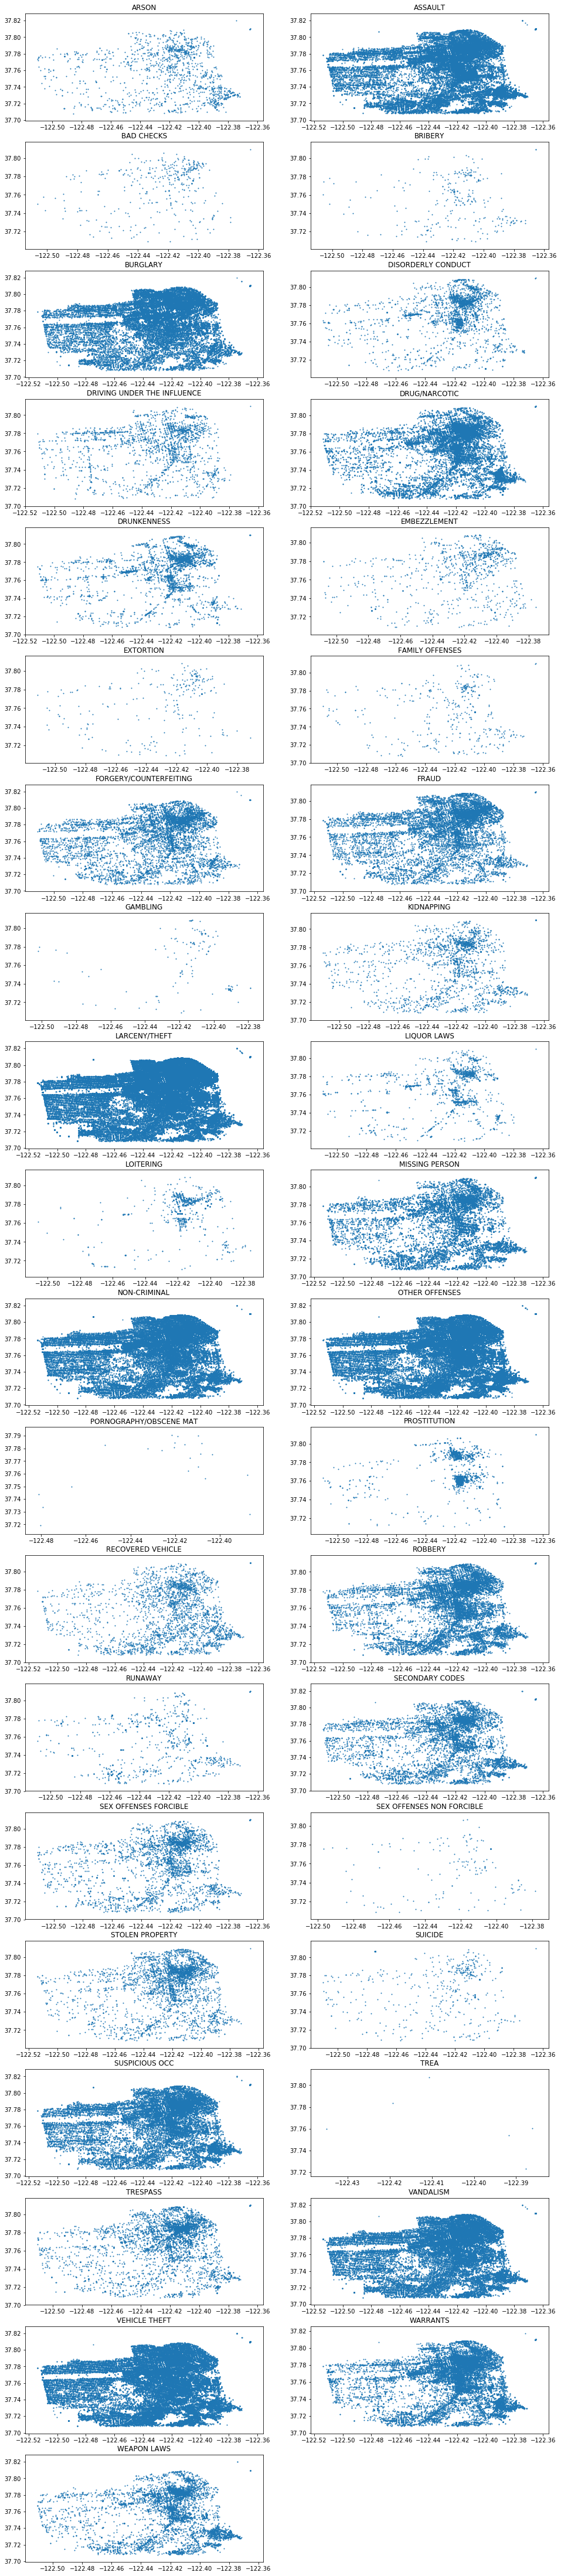

In [102]:
#Plot 2D Coordinates for each Point by Crime Category
plt.figure(figsize=(16,80))
for i in range(n_classes):
    plt.subplot(20,2,i+1)
    plt.title(le.inverse_transform(i))
    plt.scatter(list(X_cat[Y_le==i][:,-2]),list(X_cat[Y_le==i][:,-1]), s=1)

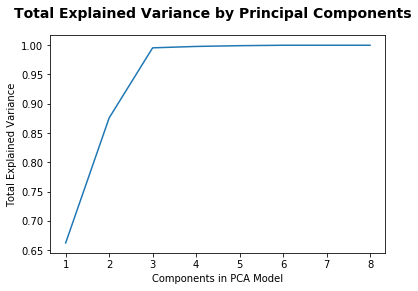

In [21]:
exp_var = []
pc = []

#Fit PCA models over different component numbers
for i in range(1,9):
    pca = PCA(n_components=i)
    pca.fit(X_cat)
    exp_var.append(sum(pca.explained_variance_ratio_))
    pc.append(i)

#Plot explained variance ratio vs. number of components in PCA
fig = plt.figure()
fig.suptitle("Total Explained Variance by Principal Components", fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Components in PCA Model')
ax.set_ylabel('Total Explained Variance')
ax.plot(pc,exp_var)
plt.show()

In [22]:
#PCA with 3 components is the best choice
#Transform X_cat into its 3 Components
pca = PCA(n_components=3)
pca.fit(X_cat)
X_cat = pca.transform(X_cat)

In [27]:
#Encode categories into digits
le = preprocessing.LabelEncoder()
le.fit(Y)
n_classes = len(le.classes_)
Y_le = le.transform(Y)

#Create sub train and dev data sets
train_NS2 = X_cat[len(X_cat)//2:]
trlabs_NS2 = Y_le[len(X_cat)//2:]
dev_NS2 = X_cat[:len(X_cat)//2]
devlabs_NS2 = Y_le[:len(X_cat)//2]

In [209]:
#Function to count number of parameters given 3D data, GMM Covar Type, and GMM Components
def count_params(s, g):
    if s == "spherical":
        return (3+1)*g
    if s == "diag":
        return (3+3)*g
    if s == "tied":
        return 3*g + 6
    if s == "full":
        return (3+6)*g

g_min = 1
g_max = 1
g_st = 1
g_comps = np.arange(g_min,g_max+1,g_st)
#structures = ['spherical', 'diag', 'tied', 'full']
structures = ['diag']

#Collection of GMM scores for each category
cat_scores = []
for i in range(n_classes):
    print ""
    print ""
    print "Processing Category %s" %le.inverse_transform(i)
    print "Frequency in Train Data: %d" %freqs[i]
    votes = (1000*freqs[i])//len(train_NS2)
    print "Number of votes per 1000: %d" %votes
    
    subset = train_NS2[trlabs_NS2==i] 
    #Collection of scores for each structure over each number of GMM components
    struc_scores = []
    for s in structures:
    
        #Collection of scores of each number of viable GMM components for structure s
        structure = []
        for g in g_comps:
            
            if count_params(s, g) < 200:
                
                #If length of subset is less than the number of GMM components, make all scores very improbable
                if g > len(subset):
                    scores = [-1000000]*len(dev_NS2)
                else:
                    #Fit a g-comp, s-covar model to crime category subset 
                    gm_mod = GaussianMixture(n_components = g, covariance_type = s)
                    GMM = gm_mod.fit(subset)
                    
                    #Calculate score from each model and append to structure
                    scores = GMM.score_samples(dev_NS2)
                    print ""
                    print "Structure: %s GMM Components: %d " %(s,g)
                    print "Top 10 Scores:"
                    print scores[np.argsort(scores)[-10:]]
                    print "Top 10 Indices:"
                    print np.argsort(scores)[-10:]
                    
                structure.append(scores)
                GMM = None
                gm_mod = None
                
        #Append Structure Scores with Individual Structure Scores.
        struc_scores.append(structure)
        
    #Append all possible GMM scores to Category Scores
    cat_scores.append(struc_scores)

print ""
print "Processing Complete"



Processing Category ARSON
Frequency in Train Data: 784
Number of votes per 1000: 1

Structure: diag GMM Components: 1 
Top 10 Scores:
[-9.67547111 -9.67547111 -9.67547111 -9.67547111 -9.67547111 -9.67547111
 -9.67547111 -9.67547111 -9.67547111 -9.67547111]
Top 10 Indices:
[286438 218172  68659  68660 354221 354226 286428 143997  68666 143994]


Processing Category ASSAULT
Frequency in Train Data: 38710
Number of votes per 1000: 88

Structure: diag GMM Components: 1 
Top 10 Scores:
[-9.59887796 -9.59887796 -9.59887796 -9.59887796 -9.59887796 -9.59887796
 -9.59887795 -9.59887795 -9.59887795 -9.59887795]
Top 10 Indices:
[280349 280346 347970 347969 280356 280353 347962 280359 280357 280348]


Processing Category BAD CHECKS
Frequency in Train Data: 280
Number of votes per 1000: 0

Structure: diag GMM Components: 1 
Top 10 Scores:
[-9.48576834 -9.48576834 -9.48576834 -9.48576834 -9.48576834 -9.48576834
 -9.48576834 -9.48576834 -9.48576834 -9.48576834]
Top 10 Indices:
[212075 280774 348379

In [210]:
#Create a vector to store the frequencies of each category
freqs = []
for i in range(n_classes):
    freqs.append(len(train_NS2[trlabs_NS2==i]))

#Initialize scores to most frequent category
most_freq = np.argsort(freqs)[-1]
print "Most Frequent Crime: %s at %3.3f%%" %(le.inverse_transform(np.argsort(freqs)[-1]), 100*float(freqs[most_freq])/float(len(dev_NS2)))
preds = [most_freq]*len(dev_NS2)
probs = [-10000.0]*len(dev_NS2)


#Start with the least frequent category and cast votes based on population size.
#Votes are cast by probability of score 
num_wrong = [0]*n_classes
num_right = [0]*n_classes
votes_vec = [0]*n_classes
freq_inds = np.argsort(freqs)

#Go through each crime category, starting with the least frequent
for freq_ind in freq_inds:
    nw = 0
    nr = 0
    votes = (len(dev_NS2)*freqs[freq_ind])//len(train_NS2)
    votes_vec[freq_ind] = votes
    if votes > 0:
        pred_inds = np.argsort(cat_scores[freq_ind][0][0])[-votes:]
        for pred_ind in pred_inds:   
            preds[pred_ind] = freq_ind
            probs[pred_ind] = float(cat_scores[freq_ind][0][0][pred_ind])
            if devlabs_NS2[pred_ind] != freq_ind:
                nw += 1
            else:
                nr += 1
    num_wrong[freq_ind] = nw
    num_right[freq_ind] = nr

print "Model Accuracy: %3.3f%%" %(100*np.mean(preds == devlabs_NS2))


Most Frequent Crime: LARCENY/THEFT at 17.987%
Model Accuracy: 21.834%


In [223]:
print "\nCorrect Estimates by Crime Category:"
print num_wrong
print "\nCorrect Estimates by Crime Category:"
print num_right
print "\nOverall Frequency by Crime Category"
print freqs


Correct Estimates by Crime Category:
[784, 35660, 280, 113, 18549, 2288, 898, 29228, 2099, 682, 124, 270, 7159, 8040, 82, 976, 60510, 1097, 871, 11718, 34920, 54058, 15, 4690, 1547, 11436, 1083, 4130, 1980, 78, 1760, 285, 13600, 0, 3614, 20784, 34710, 20940, 4053]

Correct Estimates by Crime Category:
[0, 3050, 0, 0, 742, 5, 0, 1947, 2, 0, 0, 0, 92, 214, 0, 5, 18452, 1, 0, 424, 5509, 9208, 0, 10, 7, 219, 2, 45, 4, 1, 13, 0, 621, 0, 33, 883, 1234, 1126, 31]

Overall Frequency by Crime Category
[784, 38710, 280, 113, 19291, 2293, 898, 31175, 2101, 682, 124, 270, 7251, 8254, 82, 981, 78962, 1098, 871, 12142, 40429, 63266, 15, 4700, 1554, 11655, 1085, 4175, 1984, 79, 1773, 285, 14221, 0, 3647, 21667, 35944, 22066, 4084]


In [221]:
#Implement Adaboost-like method to reduce error of worst performing category


#Perform Gradient Descent with Accuracy as Cost Function and GMM Components as Step


def Best_GMM(cat = worst_cat, g = 5, loops = 10, g_step = 5, s = "diag", threshold = 0.1):
    
    old_wrong = num_wrong[cat]
    subset = train_NS2[trlabs_NS2==cat]
    direction = "pos"
    deriv = 0
    best_deriv = np.inf
    integ = 0
    prob = 0
    
    for i in range(loops):
        
        print "\nOld Wrong: %d" %old_wrong
        
        preds_test = preds 
        gm_mod = GaussianMixture(n_components = g, covariance_type = s)
        GMM = gm_mod.fit(subset)
        scores = GMM.score_samples(dev_NS2)

        new_wrong = 0
        votes = (len(dev_NS2)*freqs[cat])//len(train_NS2)
        if votes > 0:
            pred_inds = np.argsort(scores)[-votes:]
            for pred_ind in pred_inds:   
                preds_test[pred_ind] = cat
                if devlabs_NS2[pred_ind] != cat:
                    new_wrong += 1
        
        print "New Wrong: %d" %new_wrong
        
        if float(new_wrong)/float(num_wrong[cat]) <= threshold:
            print "Best GMM Comps: %d" %g
            return best_g
        
        #Utilize PID Control Method to Drive Wrong to Zero
        #prop = new_wrong
        deriv = new_wrong - old_wrong
        if deriv < best_deriv:
            best_g = g
        
        #integ += deriv
        
        if deriv < 0 and direction == "pos":
            g += g_step
        elif deriv > 0 and direction == "pos":
            g -= g_step
            direction = "neg"
        elif deriv > 0 and direction == "neg":
            g += g_step
            direction = "pos"
        else:
            g -= g_step
 
        if g <= 0:
            print "Did Not Converge"
            break
    
        print "Loop %d: %3.3f%% Best g: %d" %(i, 100*np.mean(preds_test == devlabs_NS2), g)

    
    #Update num_wrong metric from before
    num_wrong[cat] = new_wrong
    return best_g



iters = 1
for i in range(iters):
    #Find the category with the worst performance overall (most incorrect labels)
    worst_cat = np.argsort(num_wrong)[-1]
    #Work on it while we have iterations
    Best_GMM()




Old Wrong: 60510
New Wrong: 60284
Loop 0: 21.846%

Old Wrong: 60510
New Wrong: 59409
Loop 1: 21.846%

Old Wrong: 60510
New Wrong: 59233
Loop 2: 21.846%

Old Wrong: 60510
New Wrong: 58679
Loop 3: 21.846%

Old Wrong: 60510
New Wrong: 58781
Loop 4: 21.846%

Old Wrong: 60510
New Wrong: 59153
Loop 5: 21.846%

Old Wrong: 60510
New Wrong: 58678
Loop 6: 21.846%

Old Wrong: 60510
New Wrong: 59698
Loop 7: 21.848%

Old Wrong: 60510
New Wrong: 59508
Loop 8: 21.848%

Old Wrong: 60510
New Wrong: 61547
Loop 9: 21.848%


50